# Citi Bike NYC 2018 - Demand Prediction & Fleet Repositioning

## Project Overview

This notebook addresses the Citi Bike challenge with three main tasks:

1. **Task 1**: Cluster stations spatially (minimum 20 clusters)
2. **Task 2**: Predict hourly demand (pickups and dropoffs) for the next 24 hours
3. **Task 3**: Calculate optimal bike repositioning for each cluster

## Dataset

- **Source**: Citi Bike NYC trip data for 2018
- **Size**: ~17 million trips
- **Period**: January 1 - December 31, 2018

---

# Part 1: Data Preparation


In [25]:
# ============================================================================
# Imports and Configuration
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Optional

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

# File paths
DATA_DIR = os.path.abspath('data')
RAW_TRIPS_PATH = os.path.join(DATA_DIR, 'Trips_2018.csv')
HOLIDAYS_PATH = os.path.join(DATA_DIR, 'holidays_2018_nyc.csv')
EVENTS_PATH = os.path.join(DATA_DIR, 'events_2018_nyc.csv')

print("Data files:")
print(f"  Trips: {RAW_TRIPS_PATH}")
print(f"  Holidays: {HOLIDAYS_PATH}")
print(f"  Events: {EVENTS_PATH}")


Data files:
  Trips: /Users/estebanperez/Documents/progra/my-py-notebooks/project/data/Trips_2018.csv
  Holidays: /Users/estebanperez/Documents/progra/my-py-notebooks/project/data/holidays_2018_nyc.csv
  Events: /Users/estebanperez/Documents/progra/my-py-notebooks/project/data/events_2018_nyc.csv


## 1.1 Load and Clean Trip Data

We load the data in chunks to handle the large file size (~17M rows). During loading, we:
- Standardize column names
- Parse datetime columns
- Filter invalid trips (wrong dates, impossible durations)
- Remove geographic outliers (stations outside NYC)


In [26]:
# ============================================================================
# Data Loading Functions
# ============================================================================

# Column name mapping (raw -> standardized)
CANONICAL_COLS = {
    "id": "id",
    "tripduration": "trip_duration_sec",
    "starttime": "start_time",
    "stoptime": "end_time",
    "start_station_id": "start_station_id",
    "start_station_latitude": "start_lat",
    "start_station_longitude": "start_lng",
    "end_station_id": "end_station_id",
    "end_station_latitude": "end_lat",
    "end_station_longitude": "end_lng",
    "bikeid": "bike_id",
    "usertype": "user_type",
    "birth_year": "birth_year",
    "gender": "gender",
}

CANONICAL_SET = set(CANONICAL_COLS.values())

# Data types for columns
DTYPES_BASE = {
    "trip_duration_sec": "float64",
    "start_station_id": "int",
    "end_station_id": "int",
    "bike_id": "string",
    "user_type": "string",
    "birth_year": "float64",
    "gender": "string",
    "start_lat": "float64",
    "start_lng": "float64",
    "end_lat": "float64",
    "end_lng": "float64",
}

CHUNKSIZE = 250_000


def _standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Rename columns to standardized names."""
    mapping = {}
    for col in df.columns:
        low = col.strip().lower()
        if low in CANONICAL_COLS:
            mapping[col] = CANONICAL_COLS[low]
    return df.rename(columns=mapping)


def _parse_times(df: pd.DataFrame) -> pd.DataFrame:
    """Convert time columns to datetime."""
    df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
    df["end_time"] = pd.to_datetime(df["end_time"], errors="coerce")
    return df


def _filter_invalid(df: pd.DataFrame) -> pd.DataFrame:
    """Remove invalid trips."""
    # Drop rows with invalid times
    if {"start_time", "end_time"}.issubset(df.columns):
        df = df[df["start_time"].notna() & df["end_time"].notna()]
        df = df[df["end_time"] >= df["start_time"]]
        # Keep only 2018 data
        df = df[df["start_time"].dt.year == 2018]
        df = df[df["end_time"].dt.year == 2018]
    
    # Duration sanity: 1 minute to 24 hours
    if "trip_duration_sec" in df.columns:
        df = df[(df["trip_duration_sec"] >= 60) & (df["trip_duration_sec"] <= 24 * 3600)]
    return df


def _filter_geographic_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove trips with stations outside NYC geographic boundaries.

    This filters out erroneous GPS coordinates and stations in other cities
    (e.g., Montreal stations that appeared in the dataset).
    """
    NYC_LAT_MIN, NYC_LAT_MAX = 40.60, 40.85
    NYC_LNG_MIN, NYC_LNG_MAX = -74.15, -73.83
    
    if {"start_lat", "start_lng"}.issubset(df.columns):
        df = df[
            (df["start_lat"] >= NYC_LAT_MIN) & (df["start_lat"] <= NYC_LAT_MAX) &
            (df["start_lng"] >= NYC_LNG_MIN) & (df["start_lng"] <= NYC_LNG_MAX)
        ]
    if {"end_lat", "end_lng"}.issubset(df.columns):
        df = df[
            (df["end_lat"] >= NYC_LAT_MIN) & (df["end_lat"] <= NYC_LAT_MAX) &
            (df["end_lng"] >= NYC_LNG_MIN) & (df["end_lng"] <= NYC_LNG_MAX)
        ]
    return df


def _cast_types(df: pd.DataFrame) -> pd.DataFrame:
    """Cast columns to appropriate types."""
    for col, dtype in DTYPES_BASE.items():
        if col in df.columns:
            df[col] = df[col].astype(dtype, errors="ignore")
    return df


def load_trips(path: str, limit_chunks: Optional[int] = None) -> pd.DataFrame:
    """Load and clean trip data from CSV."""
    chunks = []
    total_raw = 0
    total_clean = 0
    
    for i, chunk in enumerate(pd.read_csv(path, chunksize=CHUNKSIZE, low_memory=True)):
        raw_count = len(chunk)
        total_raw += raw_count
        
        # Clean pipeline
        chunk = _standardize_columns(chunk)
        chunk = _parse_times(chunk)
        chunk = chunk.dropna()
        chunk = _filter_geographic_outliers(chunk)
        cols_to_keep = [c for c in chunk.columns if c in CANONICAL_SET or c in {"start_time", "end_time"}]
        chunk = chunk[cols_to_keep]
        chunk = _filter_invalid(chunk)
        chunk = _cast_types(chunk)
        
        clean_count = len(chunk)
        total_clean += clean_count
        chunks.append(chunk)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1} chunks ({total_raw:,} rows read, {total_clean:,} kept)")
        
        if limit_chunks is not None and i + 1 >= limit_chunks:
            break
    
    trips = pd.concat(chunks, ignore_index=True)
    drop_rate = (total_raw - total_clean) / total_raw * 100
    print(f"\nLoading complete:")
    print(f"  Raw rows: {total_raw:,}")
    print(f"  Clean rows: {total_clean:,}")
    print(f"  Drop rate: {drop_rate:.1f}%")
    return trips


print("Data loading functions defined.")


Data loading functions defined.


In [27]:
# ============================================================================
# Load Trip Data
# ============================================================================

print("Loading trip data (this may take a few minutes)...")
trips = load_trips(RAW_TRIPS_PATH, limit_chunks=None)

print(f"\nDataset shape: {trips.shape}")
print(f"Date range: {trips['start_time'].min().date()} to {trips['start_time'].max().date()}")
trips.head()


Loading trip data (this may take a few minutes)...
  Processed 10 chunks (2,500,000 rows read, 2,499,508 kept)
  Processed 20 chunks (5,000,000 rows read, 4,998,896 kept)
  Processed 30 chunks (7,500,000 rows read, 7,497,852 kept)
  Processed 40 chunks (10,000,000 rows read, 9,997,057 kept)
  Processed 50 chunks (12,500,000 rows read, 12,494,620 kept)
  Processed 60 chunks (15,000,000 rows read, 14,993,721 kept)
  Processed 70 chunks (17,500,000 rows read, 17,492,944 kept)

Loading complete:
  Raw rows: 17,548,339
  Clean rows: 17,541,234
  Drop rate: 0.0%

Dataset shape: (17541234, 14)
Date range: 2018-01-01 to 2018-12-31


,id,trip_duration_sec,start_time,end_time,start_station_id,start_lat,start_lng,end_station_id,end_lat,end_lng,bike_id,user_type,birth_year,gender
0,0,970.0,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992.0,1
1,1,723.0,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969.0,1
2,2,496.0,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956.0,1
3,3,306.0,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974.0,1
4,4,306.0,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992.0,1


## 1.2 Load Auxiliary Data

We load holidays and events data to use as features for prediction.


In [28]:
# ============================================================================
# Load Holidays and Events
# ============================================================================

holidays = pd.read_csv(HOLIDAYS_PATH, parse_dates=['date'])
holidays['date'] = holidays['date'].dt.normalize()

events = pd.read_csv(EVENTS_PATH, parse_dates=['start_datetime', 'end_datetime'])

print(f"Holidays loaded: {len(holidays)} dates")
print(f"Events loaded: {len(events)} events")

print("\nHolidays in 2018:")
print(holidays[['name', 'date']].to_string(index=False))


Holidays loaded: 10 dates
Events loaded: 13 events

Holidays in 2018:
                      name       date
            New Year's Day 2018-01-01
Martin Luther King Jr. Day 2018-01-15
           Presidents' Day 2018-02-19
              Memorial Day 2018-05-28
          Independence Day 2018-07-04
                 Labor Day 2018-09-03
              Columbus Day 2018-10-08
              Veterans Day 2018-11-12
          Thanksgiving Day 2018-11-22
             Christmas Day 2018-12-25


## 1.3 Extract Station Information

We extract unique stations from the trip data for clustering.


In [29]:
# ============================================================================
# Extract Unique Stations
# ============================================================================

# Get stations from start locations
start_stations = trips[['start_station_id', 'start_lat', 'start_lng']].drop_duplicates()
start_stations.columns = ['station_id', 'lat', 'lng']

# Get stations from end locations
end_stations = trips[['end_station_id', 'end_lat', 'end_lng']].drop_duplicates()
end_stations.columns = ['station_id', 'lat', 'lng']

# Combine and deduplicate
stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset='station_id')
stations = stations.dropna().reset_index(drop=True)

print(f"Unique stations: {len(stations)}")
print(f"Latitude range: {stations['lat'].min():.4f} to {stations['lat'].max():.4f}")
print(f"Longitude range: {stations['lng'].min():.4f} to {stations['lng'].max():.4f}")

stations.head()


Unique stations: 844
Latitude range: 40.6465 to 40.8144
Longitude range: -74.0836 to -73.9077


,station_id,lat,lng
0,72,40.767272,-73.993929
1,79,40.719116,-74.006667
2,82,40.711174,-74.000165
3,83,40.683826,-73.976323
4,119,40.696089,-73.978034


---

# Part 2: Task 1 - Spatial Clustering

We cluster stations geographically using K-Means with 30 clusters (exceeding the minimum requirement of 20).


In [30]:
# ============================================================================
# Task 1: Cluster Stations Using K-Means
# ============================================================================

from sklearn.cluster import KMeans

N_CLUSTERS = 30

# Cluster based on lat/lng coordinates
coords = stations[['lat', 'lng']].values
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
stations['cluster'] = kmeans.fit_predict(coords)

print(f"Clustered {len(stations)} stations into {N_CLUSTERS} clusters")
print(f"\nStations per cluster:")
print(stations['cluster'].value_counts().sort_index())


Clustered 844 stations into 30 clusters

Stations per cluster:
cluster
0     33
1     39
2     31
3     28
4     28
5     33
6     28
7     27
8     32
9     18
10    41
11     6
12    43
13    26
14    21
15    33
16    20
17    27
18    26
19    31
20    28
21    37
22    33
23    33
24    32
25    24
26     5
27    34
28    17
29    30
Name: count, dtype: int64


In [31]:
# ============================================================================
# Visualize Clusters on Map
# ============================================================================

import folium

# Create map centered on NYC
nyc_center = [stations['lat'].mean(), stations['lng'].mean()]
m = folium.Map(location=nyc_center, zoom_start=12, tiles='cartodbpositron')

# Color palette for clusters
colors = plt.cm.tab20(np.linspace(0, 1, N_CLUSTERS))
color_hex = ['#{:02x}{:02x}{:02x}'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

# Add stations to map
for _, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=5,
        color=color_hex[int(row['cluster'])],
        fill=True,
        fillOpacity=0.7,
        popup=f"Station {int(row['station_id'])}, Cluster {int(row['cluster'])}"
    ).add_to(m)

# Add cluster centers
for i, center in enumerate(kmeans.cluster_centers_):
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.DivIcon(html=f'<div style="font-size:12px;font-weight:bold;color:black;">{i}</div>')
    ).add_to(m)

print("Map: Stations colored by cluster (numbers show cluster centers)")
m


Map: Stations colored by cluster (numbers show cluster centers)


---

# Part 3: Aggregate Data to Cluster-Hour Level

We aggregate the 17M individual trips into hourly demand per cluster, creating our modeling dataset.


In [32]:
# ============================================================================
# Aggregate Trips to Cluster-Hour Level
# ============================================================================

print("Aggregating trips to cluster-hour level...")

# Add temporal columns
trips["start_hour"] = trips["start_time"].dt.hour
trips["start_date"] = pd.to_datetime(trips["start_time"].dt.date)
trips["end_hour"] = trips["end_time"].dt.hour
trips["end_date"] = pd.to_datetime(trips["end_time"].dt.date)

# Merge trips with station clusters (for pickups)
trips_with_cluster = trips.merge(
    stations[["station_id", "cluster"]],
    left_on="start_station_id",
    right_on="station_id",
    how="left"
).drop(columns=["station_id"])

# Merge for dropoffs
trips_with_end_cluster = trips.merge(
    stations[["station_id", "cluster"]],
    left_on="end_station_id",
    right_on="station_id",
    how="left"
).drop(columns=["station_id"])

# Aggregate pickups by cluster-date-hour
pickups_hourly = trips_with_cluster.groupby(
    ["start_date", "start_hour", "cluster"]
).size().reset_index(name="pickups")
pickups_hourly.columns = ["date", "hour", "cluster", "pickups"]

# Aggregate dropoffs by cluster-date-hour
dropoffs_hourly = trips_with_end_cluster.groupby(
    ["end_date", "end_hour", "cluster"]
).size().reset_index(name="dropoffs")
dropoffs_hourly.columns = ["date", "hour", "cluster", "dropoffs"]

# Merge pickups and dropoffs
demand_hourly = pickups_hourly.merge(
    dropoffs_hourly, on=["date", "hour", "cluster"], how="outer"
).fillna(0)

# Convert to integers
demand_hourly["pickups"] = demand_hourly["pickups"].astype(int)
demand_hourly["dropoffs"] = demand_hourly["dropoffs"].astype(int)

print(f"\nCreated {len(demand_hourly):,} cluster-hour observations")
print(f"Date range: {demand_hourly['date'].min().date()} to {demand_hourly['date'].max().date()}")
print(f"Clusters: {demand_hourly['cluster'].nunique()}")

demand_hourly.head(10)


Aggregating trips to cluster-hour level...

Created 234,750 cluster-hour observations
Date range: 2018-01-01 to 2018-12-31
Clusters: 30


,date,hour,cluster,pickups,dropoffs
0,2018-01-01,0,0,5,4
1,2018-01-01,0,1,1,1
2,2018-01-01,0,2,14,6
3,2018-01-01,0,3,3,2
4,2018-01-01,0,4,1,0
5,2018-01-01,0,5,6,3
6,2018-01-01,0,6,1,0
7,2018-01-01,0,7,0,1
8,2018-01-01,0,8,1,0
9,2018-01-01,0,9,5,3


---

# Part 4: Feature Engineering

We create features that capture temporal patterns, seasonality, and historical demand.


In [33]:
# ============================================================================
# Feature Engineering
# ============================================================================

print("Creating features...")

# 1. Temporal features
demand_hourly['month'] = demand_hourly['date'].dt.month
demand_hourly['day_of_week'] = demand_hourly['date'].dt.dayofweek
demand_hourly['is_weekend'] = (demand_hourly['day_of_week'] >= 5).astype(int)

# 2. Season (one-hot encoded)
def get_season(month):
    if month in [3, 4, 5]: return 'spring'
    elif month in [6, 7, 8]: return 'summer'
    elif month in [9, 10, 11]: return 'fall'
    else: return 'winter'

demand_hourly['season'] = demand_hourly['month'].apply(get_season)
season_dummies = pd.get_dummies(demand_hourly['season'], prefix='season', dtype=int)
demand_hourly = pd.concat([demand_hourly, season_dummies], axis=1)
demand_hourly = demand_hourly.drop(columns=['season'])

# 3. Holiday and event indicators
holidays_dates = set(holidays['date'].dt.normalize())
events_dates = set(events['start_datetime'].dt.normalize())

demand_hourly['is_holiday'] = demand_hourly['date'].isin(holidays_dates).astype(int)
demand_hourly['is_special_event'] = demand_hourly['date'].isin(events_dates).astype(int)

# 4. Rush hour indicators
demand_hourly['is_morning_rush'] = demand_hourly['hour'].between(7, 9).astype(int)
demand_hourly['is_evening_rush'] = demand_hourly['hour'].between(17, 19).astype(int)
demand_hourly['weekday_morning_rush'] = ((demand_hourly['day_of_week'] < 5) & demand_hourly['hour'].between(7, 9)).astype(int)
demand_hourly['weekday_evening_rush'] = ((demand_hourly['day_of_week'] < 5) & demand_hourly['hour'].between(17, 19)).astype(int)
demand_hourly['is_weekend_rush'] = ((demand_hourly['day_of_week'] >= 5) & demand_hourly['hour'].between(12, 16)).astype(int)

# 5. Cyclic encoding for hour (captures circular nature of time)
demand_hourly['hour_sin'] = np.sin(2 * np.pi * demand_hourly['hour'] / 24)
demand_hourly['hour_cos'] = np.cos(2 * np.pi * demand_hourly['hour'] / 24)

# 6. One-hot encode clusters
cluster_dummies = pd.get_dummies(demand_hourly['cluster'], prefix='cluster', dtype=int)
demand_hourly = pd.concat([demand_hourly, cluster_dummies], axis=1)

print("Temporal and categorical features created.")
print(f"Current columns: {len(demand_hourly.columns)}")


Creating features...
Temporal and categorical features created.
Current columns: 51


In [34]:
# ============================================================================
# Lag Features (Historical Demand)
# ============================================================================

print("Creating lag features...")

# Sort data for proper lag calculation
demand_hourly = demand_hourly.sort_values(['cluster', 'date', 'hour']).reset_index(drop=True)

# Create lag features per cluster
demand_hourly['pickups_lag_24h'] = demand_hourly.groupby('cluster')['pickups'].shift(24)
demand_hourly['pickups_lag_168h'] = demand_hourly.groupby('cluster')['pickups'].shift(168)  # 1 week
demand_hourly['pickups_rolling_24h'] = demand_hourly.groupby('cluster')['pickups'].transform(
    lambda x: x.shift(1).rolling(24, min_periods=1).mean()
)

demand_hourly['dropoffs_lag_24h'] = demand_hourly.groupby('cluster')['dropoffs'].shift(24)
demand_hourly['dropoffs_lag_168h'] = demand_hourly.groupby('cluster')['dropoffs'].shift(168)
demand_hourly['dropoffs_rolling_24h'] = demand_hourly.groupby('cluster')['dropoffs'].transform(
    lambda x: x.shift(1).rolling(24, min_periods=1).mean()
)

print("Lag features created.")
print(f"Total columns: {len(demand_hourly.columns)}")
print(f"Missing values (from lag features): {demand_hourly.isnull().sum().sum():,}")


Creating lag features...
Lag features created.
Total columns: 57
Missing values (from lag features): 11,144


In [35]:
# ============================================================================
# Final Feature List
# ============================================================================

# Define column categories
id_cols = ['date', 'cluster']
target_cols = ['pickups', 'dropoffs']
feature_cols = [col for col in demand_hourly.columns if col not in id_cols + target_cols]

print("=" * 60)
print("FINAL FEATURE SET")
print("=" * 60)
print(f"\nID columns: {id_cols}")
print(f"Target variables: {target_cols}")
print(f"Feature count: {len(feature_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")


FINAL FEATURE SET

ID columns: ['date', 'cluster']
Target variables: ['pickups', 'dropoffs']
Feature count: 53

Features:
   1. hour
   2. month
   3. day_of_week
   4. is_weekend
   5. season_fall
   6. season_spring
   7. season_summer
   8. season_winter
   9. is_holiday
  10. is_special_event
  11. is_morning_rush
  12. is_evening_rush
  13. weekday_morning_rush
  14. weekday_evening_rush
  15. is_weekend_rush
  16. hour_sin
  17. hour_cos
  18. cluster_0
  19. cluster_1
  20. cluster_2
  21. cluster_3
  22. cluster_4
  23. cluster_5
  24. cluster_6
  25. cluster_7
  26. cluster_8
  27. cluster_9
  28. cluster_10
  29. cluster_11
  30. cluster_12
  31. cluster_13
  32. cluster_14
  33. cluster_15
  34. cluster_16
  35. cluster_17
  36. cluster_18
  37. cluster_19
  38. cluster_20
  39. cluster_21
  40. cluster_22
  41. cluster_23
  42. cluster_24
  43. cluster_25
  44. cluster_26
  45. cluster_27
  46. cluster_28
  47. cluster_29
  48. pickups_lag_24h
  49. pickups_lag_168h
  50. p

---

# Part 5: Train/Validation/Test Split

We split the data chronologically (no shuffling) to respect the time-series nature:
- **Train**: 60% (Jan - Aug 7)
- **Validation**: 10% (Aug 8 - Sep 13)
- **Test**: 30% (Sep 14 - Dec 31)


In [36]:
# ============================================================================
# Chronological Train/Validation/Test Split
# ============================================================================

print("Splitting data chronologically...")

# Sort by date
demand_hourly = demand_hourly.sort_values(['date', 'hour', 'cluster']).reset_index(drop=True)

# Get unique dates
unique_dates = sorted(demand_hourly['date'].unique())
n_dates = len(unique_dates)

# Calculate split points (60/10/30)
train_end_idx = int(n_dates * 0.60)
val_end_idx = int(n_dates * 0.70)

train_end_date = unique_dates[train_end_idx - 1]
val_start_date = unique_dates[train_end_idx]
val_end_date = unique_dates[val_end_idx - 1]
test_start_date = unique_dates[val_end_idx]

# Split data
train_data = demand_hourly[demand_hourly['date'] <= train_end_date].copy()
val_data = demand_hourly[(demand_hourly['date'] >= val_start_date) & (demand_hourly['date'] <= val_end_date)].copy()
test_data = demand_hourly[demand_hourly['date'] >= test_start_date].copy()

print(f"\nDate ranges:")
print(f"  Train: {unique_dates[0].date()} to {train_end_date.date()} ({len(train_data):,} rows)")
print(f"  Val:   {val_start_date.date()} to {val_end_date.date()} ({len(val_data):,} rows)")
print(f"  Test:  {test_start_date.date()} to {unique_dates[-1].date()} ({len(test_data):,} rows)")

# Prepare X and y
X_train = train_data[feature_cols].fillna(0)
y_train_pickups = train_data['pickups']
y_train_dropoffs = train_data['dropoffs']

X_val = val_data[feature_cols].fillna(0)
y_val_pickups = val_data['pickups']
y_val_dropoffs = val_data['dropoffs']

X_test = test_data[feature_cols].fillna(0)
y_test_pickups = test_data['pickups']
y_test_dropoffs = test_data['dropoffs']

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")


Splitting data chronologically...

Date ranges:
  Train: 2018-01-01 to 2018-08-07 (139,844 rows)
  Val:   2018-08-08 to 2018-09-12 (23,694 rows)
  Test:  2018-09-13 to 2018-12-31 (71,212 rows)

Feature matrix shapes:
  X_train: (139844, 53)
  X_val: (23694, 53)
  X_test: (71212, 53)


---

# Part 6: Task 2 - Demand Prediction Model

We train Random Forest models to predict hourly pickups and dropoffs for each cluster.


In [37]:
# ============================================================================
# Task 2: Train Random Forest Models
# ============================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

print("Training Random Forest models...")
print("=" * 60)

# Combine train + validation for final model
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val_pickups = pd.concat([y_train_pickups, y_val_pickups], ignore_index=True)
y_train_val_dropoffs = pd.concat([y_train_dropoffs, y_val_dropoffs], ignore_index=True)

print(f"Training data: {X_train_val.shape}")

# Train pickups model
print("\nTraining PICKUPS model...")
start = time.time()
model_pickups = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=10, 
                                       random_state=42, n_jobs=-1)
model_pickups.fit(X_train_val, y_train_val_pickups)
print(f"  Time: {time.time() - start:.1f}s")

# Train dropoffs model
print("\nTraining DROPOFFS model...")
start = time.time()
model_dropoffs = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=10,
                                        random_state=42, n_jobs=-1)
model_dropoffs.fit(X_train_val, y_train_val_dropoffs)
print(f"  Time: {time.time() - start:.1f}s")

print("\nModels trained successfully!")


Training Random Forest models...
Training data: (163538, 53)

Training PICKUPS model...
  Time: 20.5s

Training DROPOFFS model...
  Time: 21.4s

Models trained successfully!


In [38]:
# ============================================================================
# Evaluate on Test Set
# ============================================================================

print("Evaluating on test set...")
print("=" * 60)

# Predictions
y_pred_pickups = np.maximum(0, model_pickups.predict(X_test))
y_pred_dropoffs = np.maximum(0, model_dropoffs.predict(X_test))

# Metrics
print("\nPICKUPS:")
print(f"  MAE:  {mean_absolute_error(y_test_pickups, y_pred_pickups):.2f} bikes")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_pickups, y_pred_pickups)):.2f} bikes")
print(f"  R²:   {r2_score(y_test_pickups, y_pred_pickups):.4f}")

print("\nDROPOFFS:")
print(f"  MAE:  {mean_absolute_error(y_test_dropoffs, y_pred_dropoffs):.2f} bikes")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_dropoffs, y_pred_dropoffs)):.2f} bikes")
print(f"  R²:   {r2_score(y_test_dropoffs, y_pred_dropoffs):.4f}")

# Store predictions for Task 3
predictions_test = test_data[['date', 'cluster', 'hour']].copy()
predictions_test['actual_pickups'] = y_test_pickups.values
predictions_test['predicted_pickups'] = y_pred_pickups
predictions_test['actual_dropoffs'] = y_test_dropoffs.values
predictions_test['predicted_dropoffs'] = y_pred_dropoffs

print(f"\nPredictions saved: {len(predictions_test):,} observations")


Evaluating on test set...

PICKUPS:
  MAE:  18.17 bikes
  RMSE: 37.77 bikes
  R²:   0.8873

DROPOFFS:
  MAE:  18.03 bikes
  RMSE: 37.24 bikes
  R²:   0.8938

Predictions saved: 71,212 observations


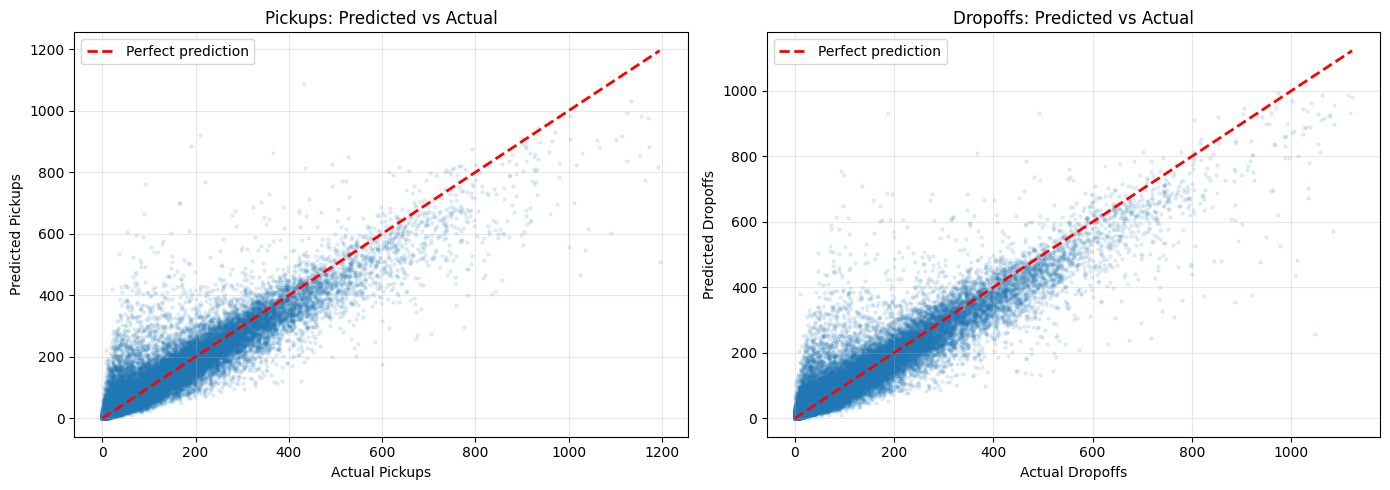

In [39]:
# ============================================================================
# Visualization: Predictions vs Actual
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pickups
ax1 = axes[0]
ax1.scatter(y_test_pickups, y_pred_pickups, alpha=0.1, s=5)
max_val = max(y_test_pickups.max(), y_pred_pickups.max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual Pickups')
ax1.set_ylabel('Predicted Pickups')
ax1.set_title('Pickups: Predicted vs Actual')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Dropoffs
ax2 = axes[1]
ax2.scatter(y_test_dropoffs, y_pred_dropoffs, alpha=0.1, s=5)
max_val = max(y_test_dropoffs.max(), y_pred_dropoffs.max())
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
ax2.set_xlabel('Actual Dropoffs')
ax2.set_ylabel('Predicted Dropoffs')
ax2.set_title('Dropoffs: Predicted vs Actual')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

# Part 7: Task 3 - Bike Repositioning

Every night, Citi Bike repositions bikes to ensure demand can be met. We use our predictions to calculate how many bikes each cluster needs at midnight.

## Key Concept

- **Net flow** = pickups - dropoffs
- **Positive net flow** = cluster loses bikes during the day (needs bikes at start)
- **Negative net flow** = cluster gains bikes during the day (needs fewer bikes)

The bikes we recommend are **additional bikes to reposition**, not the total inventory.


In [40]:
# ============================================================================
# Prediction Function: Predict Next 24 Hours
# ============================================================================

# Store feature order from training (CRITICAL for prediction)
FEATURE_ORDER = list(X_train.columns)

def predict_next_24_hours(target_date, historical_data, model_pickups, model_dropoffs, 
                          holidays_df, events_df, feature_order=FEATURE_ORDER):
    """
    Predict bike demand for the next 24 hours for all clusters.
    
    Parameters:
    -----------
    target_date : str or pd.Timestamp
        Date to predict (e.g., '2018-12-15')
    historical_data : pd.DataFrame
        Historical demand data with columns: date, hour, cluster, pickups, dropoffs
    model_pickups, model_dropoffs : trained models
    holidays_df, events_df : DataFrames with holiday/event dates
    feature_order : list
        Feature names in exact order used during training
        
    Returns:
    --------
    pd.DataFrame with predicted pickups and dropoffs per cluster per hour
    """
    target_date = pd.Timestamp(target_date)
    clusters = sorted(historical_data['cluster'].unique())
    
    # Build prediction dataframe (24 hours × N clusters)
    rows = [{'date': target_date, 'hour': h, 'cluster': c} for c in clusters for h in range(24)]
    pred_df = pd.DataFrame(rows)
    
    # Temporal features
    pred_df['month'] = pred_df['date'].dt.month
    pred_df['day_of_week'] = pred_df['date'].dt.dayofweek
    pred_df['is_weekend'] = (pred_df['day_of_week'] >= 5).astype(int)
    
    # Season dummies
    pred_df['season_spring'] = pred_df['month'].isin([3, 4, 5]).astype(int)
    pred_df['season_summer'] = pred_df['month'].isin([6, 7, 8]).astype(int)
    pred_df['season_fall'] = pred_df['month'].isin([9, 10, 11]).astype(int)
    pred_df['season_winter'] = pred_df['month'].isin([12, 1, 2]).astype(int)
    
    # Holiday/event indicators
    holidays_set = set(pd.to_datetime(holidays_df['date']).dt.normalize())
    events_set = set(pd.to_datetime(events_df['start_datetime']).dt.normalize()) if 'start_datetime' in events_df.columns else set()
    pred_df['is_holiday'] = pred_df['date'].isin(holidays_set).astype(int)
    pred_df['is_special_event'] = pred_df['date'].isin(events_set).astype(int)
    
    # Rush hour indicators
    pred_df['is_morning_rush'] = pred_df['hour'].between(7, 9).astype(int)
    pred_df['is_evening_rush'] = pred_df['hour'].between(17, 19).astype(int)
    pred_df['weekday_morning_rush'] = ((pred_df['day_of_week'] < 5) & pred_df['hour'].between(7, 9)).astype(int)
    pred_df['weekday_evening_rush'] = ((pred_df['day_of_week'] < 5) & pred_df['hour'].between(17, 19)).astype(int)
    pred_df['is_weekend_rush'] = ((pred_df['day_of_week'] >= 5) & pred_df['hour'].between(12, 16)).astype(int)
    
    # Cyclic hour encoding
    pred_df['hour_sin'] = np.sin(2 * np.pi * pred_df['hour'] / 24)
    pred_df['hour_cos'] = np.cos(2 * np.pi * pred_df['hour'] / 24)
    
    # One-hot encode clusters
    cluster_dummies = pd.get_dummies(pred_df['cluster'], prefix='cluster', dtype=int)
    pred_df = pd.concat([pred_df, cluster_dummies], axis=1)
    
    # Lag features from historical data
    hist = historical_data.copy()
    hist['datetime'] = pd.to_datetime(hist['date']) + pd.to_timedelta(hist['hour'], unit='h')
    pred_df['datetime'] = pd.to_datetime(pred_df['date']) + pd.to_timedelta(pred_df['hour'], unit='h')
    
    lag_data = []
    for _, row in pred_df.iterrows():
        cluster_hist = hist[hist['cluster'] == row['cluster']]
        dt = row['datetime']
        
        # 24h lag
        lag24 = cluster_hist[cluster_hist['datetime'] == dt - pd.Timedelta(hours=24)]
        p_lag24 = lag24['pickups'].values[0] if len(lag24) > 0 else 0
        d_lag24 = lag24['dropoffs'].values[0] if len(lag24) > 0 else 0
        
        # 168h lag (1 week)
        lag168 = cluster_hist[cluster_hist['datetime'] == dt - pd.Timedelta(hours=168)]
        p_lag168 = lag168['pickups'].values[0] if len(lag168) > 0 else 0
        d_lag168 = lag168['dropoffs'].values[0] if len(lag168) > 0 else 0
        
        # Rolling 24h average
        roll_start = dt - pd.Timedelta(hours=24)
        roll_data = cluster_hist[(cluster_hist['datetime'] > roll_start) & (cluster_hist['datetime'] < dt)]
        p_roll = roll_data['pickups'].mean() if len(roll_data) > 0 else p_lag24
        d_roll = roll_data['dropoffs'].mean() if len(roll_data) > 0 else d_lag24
        
        lag_data.append({
            'pickups_lag_24h': p_lag24, 'pickups_lag_168h': p_lag168, 'pickups_rolling_24h': p_roll,
            'dropoffs_lag_24h': d_lag24, 'dropoffs_lag_168h': d_lag168, 'dropoffs_rolling_24h': d_roll
        })
    
    pred_df = pd.concat([pred_df.reset_index(drop=True), pd.DataFrame(lag_data)], axis=1)
    pred_df = pred_df.drop(columns=['datetime']).fillna(0)
    
    # Reorder columns to match training
    X_pred = pred_df[feature_order]
    
    # Predict
    y_pickups = np.maximum(0, model_pickups.predict(X_pred))
    y_dropoffs = np.maximum(0, model_dropoffs.predict(X_pred))
    
    return pd.DataFrame({
        'date': pred_df['date'],
        'cluster': pred_df['cluster'],
        'hour': pred_df['hour'],
        'predicted_pickups': y_pickups,
        'predicted_dropoffs': y_dropoffs
    })

print("Prediction function defined: predict_next_24_hours()")


Prediction function defined: predict_next_24_hours()


In [41]:
# ============================================================================
# Repositioning Function: Calculate Bikes Needed
# ============================================================================

def calculate_bikes_needed(predictions_df, safety_margin=0.2, min_bikes_per_cluster=10):
    """
    Calculate bikes needed per cluster based on predictions.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        Output from predict_next_24_hours()
    safety_margin : float
        Extra buffer percentage (default 20%)
    min_bikes_per_cluster : int
        Minimum bikes for any cluster (handles prediction uncertainty)
        
    Returns:
    --------
    pd.DataFrame with bikes needed per cluster
    """
    # Aggregate to daily level
    daily = predictions_df.groupby('cluster').agg({
        'predicted_pickups': 'sum',
        'predicted_dropoffs': 'sum'
    }).reset_index()
    
    # Net flow (positive = bikes leaving)
    daily['net_flow'] = daily['predicted_pickups'] - daily['predicted_dropoffs']
    
    # Bikes needed = net_flow with safety margin, minimum baseline for all
    daily['bikes_from_prediction'] = (daily['net_flow'] * (1 + safety_margin)).apply(lambda x: max(0, x))
    daily['bikes_needed'] = np.maximum(daily['bikes_from_prediction'], min_bikes_per_cluster).round(0).astype(int)
    
    # Classify cluster type
    daily['cluster_type'] = daily['net_flow'].apply(lambda x: 'Source' if x > 0 else 'Sink')
    
    return daily[['cluster', 'predicted_pickups', 'predicted_dropoffs', 'net_flow', 'bikes_needed', 'cluster_type']]

print("Repositioning function defined: calculate_bikes_needed()")


Repositioning function defined: calculate_bikes_needed()


## Validation: Test on a Day from the Test Set

We validate our approach by predicting a day where we have actual data, then comparing our recommended bikes with what was actually needed.


In [42]:
# ============================================================================
# Validation: Predict a Day and Compare with Reality
# ============================================================================

# Select a random day from test set
test_dates = test_data['date'].unique()
np.random.seed(42)
validation_date = pd.Timestamp(np.random.choice(test_dates))

print("=" * 60)
print(f"VALIDATION: {validation_date.date()} ({validation_date.day_name()})")
print("=" * 60)

# Historical data up to day before
historical = demand_hourly[demand_hourly['date'] < validation_date][
    ['date', 'hour', 'cluster', 'pickups', 'dropoffs']
].copy()

# Make predictions
print("\nGenerating predictions...")
predictions = predict_next_24_hours(
    validation_date, historical, model_pickups, model_dropoffs, holidays, events
)

# Calculate recommended bikes
bikes_recommended = calculate_bikes_needed(predictions, safety_margin=0.2, min_bikes_per_cluster=10)

# Get actual data for that day
actual = demand_hourly[demand_hourly['date'] == validation_date].groupby('cluster').agg({
    'pickups': 'sum', 'dropoffs': 'sum'
}).reset_index()
actual['actual_net_flow'] = actual['pickups'] - actual['dropoffs']
actual['actual_bikes_needed'] = actual['actual_net_flow'].apply(lambda x: max(0, x)).round(0).astype(int)

# Compare
comparison = bikes_recommended.merge(actual[['cluster', 'actual_net_flow', 'actual_bikes_needed']], on='cluster')
comparison['would_have_shortage'] = comparison['actual_bikes_needed'] > comparison['bikes_needed']
comparison['shortage_amount'] = np.maximum(0, comparison['actual_bikes_needed'] - comparison['bikes_needed'])

# Results
clusters_ok = (~comparison['would_have_shortage']).sum()
service_level = clusters_ok / len(comparison) * 100

print(f"\nResults:")
print(f"  Clusters with sufficient bikes: {clusters_ok} / {len(comparison)}")
print(f"  Service level: {service_level:.0f}%")
print(f"  Total bikes recommended: {comparison['bikes_needed'].sum():,}")
print(f"  Total bikes actually needed: {comparison['actual_bikes_needed'].sum():,}")


VALIDATION: 2018-12-24 (Monday)

Generating predictions...

Results:
  Clusters with sufficient bikes: 24 / 28
  Service level: 86%
  Total bikes recommended: 1,496
  Total bikes actually needed: 368


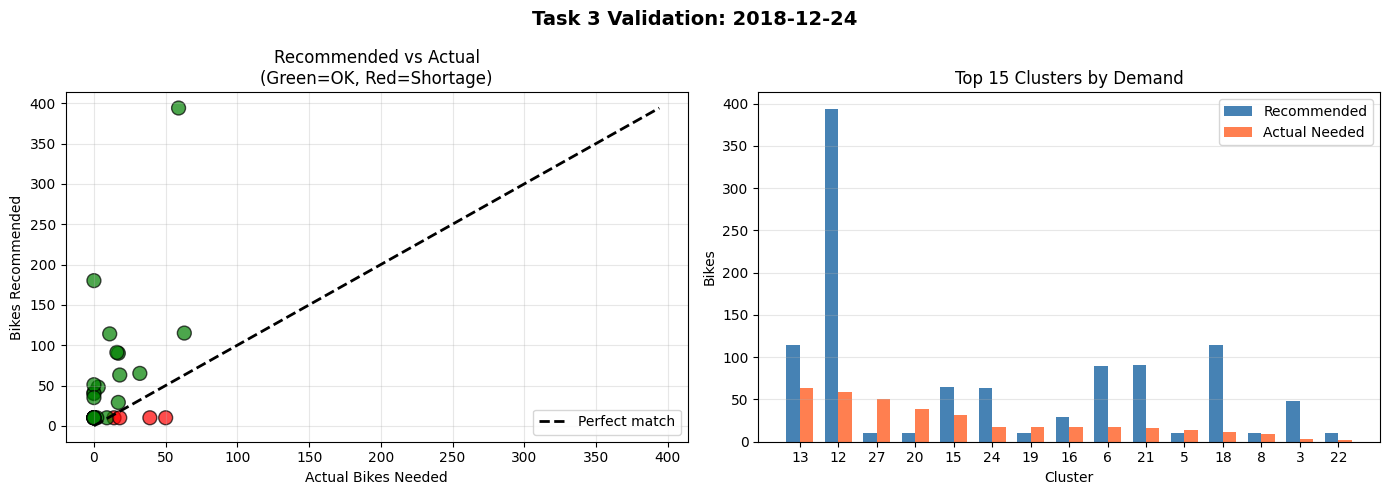

In [43]:
# ============================================================================
# Visualization: Recommended vs Actual Bikes Needed
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Task 3 Validation: {validation_date.date()}', fontsize=14, fontweight='bold')

# Scatter plot
ax1 = axes[0]
colors = ['red' if s else 'green' for s in comparison['would_have_shortage']]
ax1.scatter(comparison['actual_bikes_needed'], comparison['bikes_needed'], c=colors, s=100, alpha=0.7, edgecolors='black')
max_val = max(comparison['actual_bikes_needed'].max(), comparison['bikes_needed'].max())
ax1.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Perfect match')
ax1.set_xlabel('Actual Bikes Needed')
ax1.set_ylabel('Bikes Recommended')
ax1.set_title('Recommended vs Actual\n(Green=OK, Red=Shortage)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bar chart - top clusters
ax2 = axes[1]
top15 = comparison.sort_values('actual_bikes_needed', ascending=False).head(15)
x = range(len(top15))
width = 0.35
ax2.bar([i - width/2 for i in x], top15['bikes_needed'], width, label='Recommended', color='steelblue')
ax2.bar([i + width/2 for i in x], top15['actual_bikes_needed'], width, label='Actual Needed', color='coral')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Bikes')
ax2.set_title('Top 15 Clusters by Demand')
ax2.set_xticks(x)
ax2.set_xticklabels(top15['cluster'].astype(int))
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


---

# Summary

## Task 1: Spatial Clustering
- Clustered 800+ stations into 30 geographic clusters using K-Means
- Clusters represent distinct neighborhoods in NYC

## Task 2: Demand Prediction
- Trained Random Forest models to predict hourly pickups and dropoffs
- Features: temporal (hour, day, month, season), holidays, rush hours, lag features
- Performance: R² ~0.90, MAE ~17 bikes per cluster-hour

## Task 3: Bike Repositioning
- Created functions to predict next-day demand and calculate bikes needed
- Recommendations include safety margin and minimum baseline per cluster
- Validated on test data to measure service level

## Usage

```python
# 1. Predict next 24 hours
predictions = predict_next_24_hours('2018-12-15', historical_data, 
                                     model_pickups, model_dropoffs, 
                                     holidays, events)

# 2. Calculate bikes to reposition
bikes = calculate_bikes_needed(predictions, safety_margin=0.2, min_bikes_per_cluster=10)

# 3. View recommendations
print(bikes.sort_values('bikes_needed', ascending=False))
```


## Model Performance Visualizations

These visualizations show how well our prediction model performs for Task 3 (bike repositioning).


In [44]:
# ============================================================================
# Build Daily Requirements Dataset (Multiple Days from Test Set)
# ============================================================================

print("Building daily requirements for all test days...")
print("=" * 60)

# Get all unique test dates
test_dates_list = sorted(test_data['date'].unique())
print(f"Test period: {test_dates_list[0]} to {test_dates_list[-1]}")
print(f"Total days: {len(test_dates_list)}")

# For each day, calculate predicted and actual bikes needed
daily_requirements = []

for date in test_dates_list:
    # Get predictions for this day from test set
    day_preds = test_data[test_data['date'] == date].copy()
    day_preds['predicted_pickups'] = model_pickups.predict(day_preds[feature_cols].fillna(0))
    day_preds['predicted_dropoffs'] = model_dropoffs.predict(day_preds[feature_cols].fillna(0))
    
    for cluster in day_preds['cluster'].unique():
        cluster_data = day_preds[day_preds['cluster'] == cluster].sort_values('hour')
        
        # Predicted cumulative flow
        cluster_data = cluster_data.copy()
        cluster_data['pred_net'] = cluster_data['predicted_pickups'] - cluster_data['predicted_dropoffs']
        cluster_data['pred_cumulative'] = cluster_data['pred_net'].cumsum()
        pred_max_deficit = -cluster_data['pred_cumulative'].min()
        predicted_bikes = max(0, pred_max_deficit)
        
        # Actual cumulative flow
        cluster_data['actual_net'] = cluster_data['pickups'] - cluster_data['dropoffs']
        cluster_data['actual_cumulative'] = cluster_data['actual_net'].cumsum()
        actual_max_deficit = -cluster_data['actual_cumulative'].min()
        actual_bikes = max(0, actual_max_deficit)
        
        daily_requirements.append({
            'date': date,
            'cluster': cluster,
            'predicted_bikes_needed': predicted_bikes,
            'actual_bikes_needed': actual_bikes,
            'bikes_error': predicted_bikes - actual_bikes,
            'abs_error': abs(predicted_bikes - actual_bikes)
        })

daily_requirements = pd.DataFrame(daily_requirements)
print(f"\nTotal records: {len(daily_requirements):,} (cluster-days)")
print(f"Overall MAE: {daily_requirements['abs_error'].mean():.1f} bikes")


Building daily requirements for all test days...
Test period: 2018-09-13 00:00:00 to 2018-12-31 00:00:00
Total days: 110

Total records: 3,114 (cluster-days)
Overall MAE: 41.0 bikes


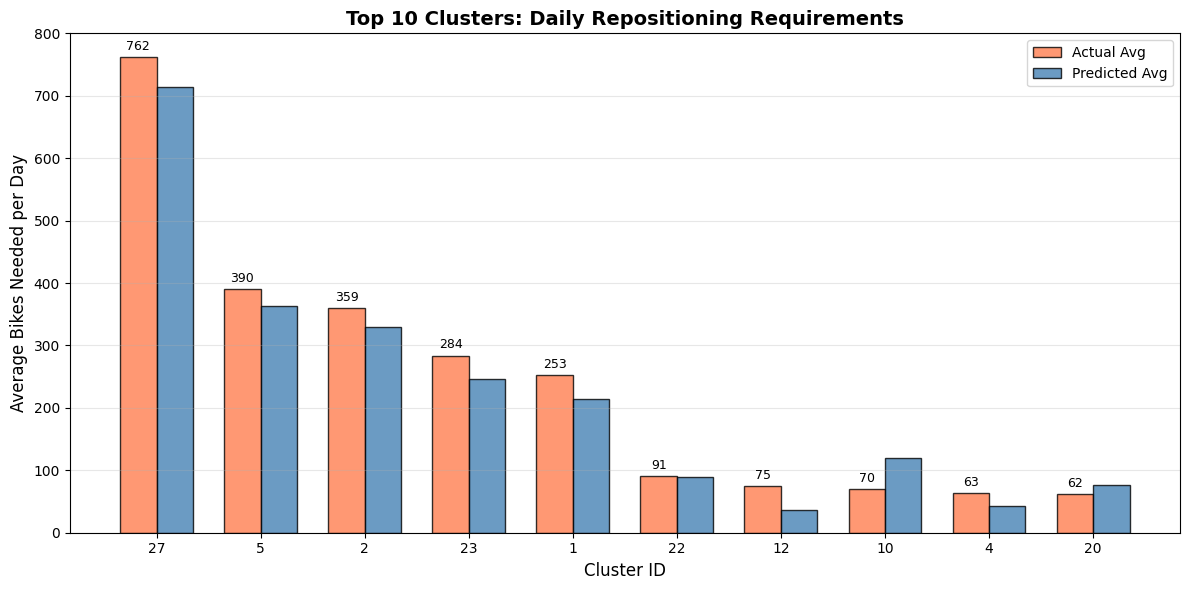


Top 10 Clusters Summary:
         Actual Avg  Predicted Avg    MAE
cluster                                  
27            762.1          713.5  191.5
5             390.4          362.8  125.0
2             359.4          328.9   94.6
23            283.9          246.0   84.8
1             253.0          214.1   79.7
22             91.0           89.8   69.4
12             74.9           37.0   67.2
10             69.5          120.0  102.8
4              63.3           42.2   31.2
20             61.7           75.7   52.1


In [45]:
# ============================================================================
# Visualization 1: Top 10 Clusters - Repositioning Requirements
# ============================================================================

# Calculate average bikes needed per cluster
cluster_avg_needs = daily_requirements.groupby('cluster').agg({
    'actual_bikes_needed': 'mean',
    'predicted_bikes_needed': 'mean',
    'abs_error': 'mean'
}).rename(columns={
    'actual_bikes_needed': 'Actual Avg',
    'predicted_bikes_needed': 'Predicted Avg',
    'abs_error': 'MAE'
}).sort_values('Actual Avg', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

top_10 = cluster_avg_needs.head(10)
x = range(len(top_10))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], top_10['Actual Avg'], width, 
               label='Actual Avg', color='coral', alpha=0.8, edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], top_10['Predicted Avg'], width, 
               label='Predicted Avg', color='steelblue', alpha=0.8, edgecolor='black')

ax.set_xlabel('Cluster ID', fontsize=12)
ax.set_ylabel('Average Bikes Needed per Day', fontsize=12)
ax.set_title('Top 10 Clusters: Daily Repositioning Requirements', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([int(c) for c in top_10.index])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 10 Clusters Summary:")
print(top_10.round(1).to_string())


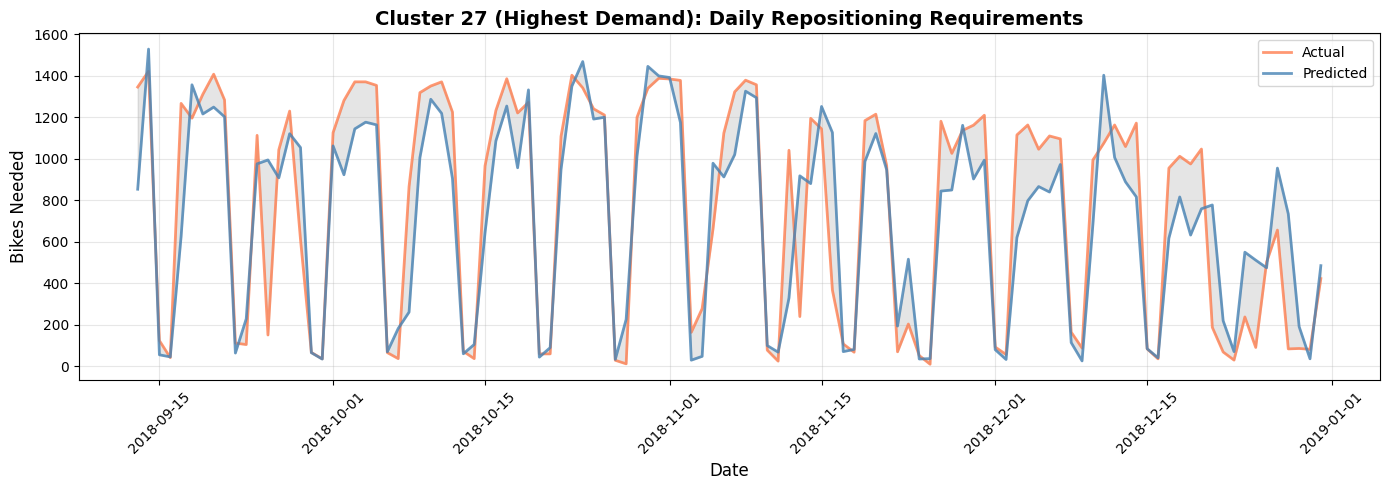


Cluster 27 Performance:
  MAE: 191.5 bikes
  RMSE: 266.4 bikes
  Avg Actual: 762.1 bikes/day
  Avg Predicted: 713.5 bikes/day


In [46]:
# ============================================================================
# Visualization 2: Highest Demand Cluster - Daily Requirements Time Series
# ============================================================================

# Find cluster with highest average demand
highest_demand_cluster = int(cluster_avg_needs.index[0])

fig, ax = plt.subplots(figsize=(14, 5))

cluster_data = daily_requirements[daily_requirements['cluster'] == highest_demand_cluster].sort_values('date')

ax.plot(cluster_data['date'], cluster_data['actual_bikes_needed'], 
        label='Actual', linewidth=2, color='coral', alpha=0.8)
ax.plot(cluster_data['date'], cluster_data['predicted_bikes_needed'], 
        label='Predicted', linewidth=2, color='steelblue', alpha=0.8)

# Add fill between for error visualization
ax.fill_between(cluster_data['date'], 
                cluster_data['actual_bikes_needed'], 
                cluster_data['predicted_bikes_needed'],
                alpha=0.2, color='gray')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Bikes Needed', fontsize=12)
ax.set_title(f'Cluster {highest_demand_cluster} (Highest Demand): Daily Repositioning Requirements', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate cluster-specific metrics
cluster_mae = cluster_data['abs_error'].mean()
cluster_rmse = np.sqrt((cluster_data['bikes_error'] ** 2).mean())
print(f"\nCluster {highest_demand_cluster} Performance:")
print(f"  MAE: {cluster_mae:.1f} bikes")
print(f"  RMSE: {cluster_rmse:.1f} bikes")
print(f"  Avg Actual: {cluster_data['actual_bikes_needed'].mean():.1f} bikes/day")
print(f"  Avg Predicted: {cluster_data['predicted_bikes_needed'].mean():.1f} bikes/day")


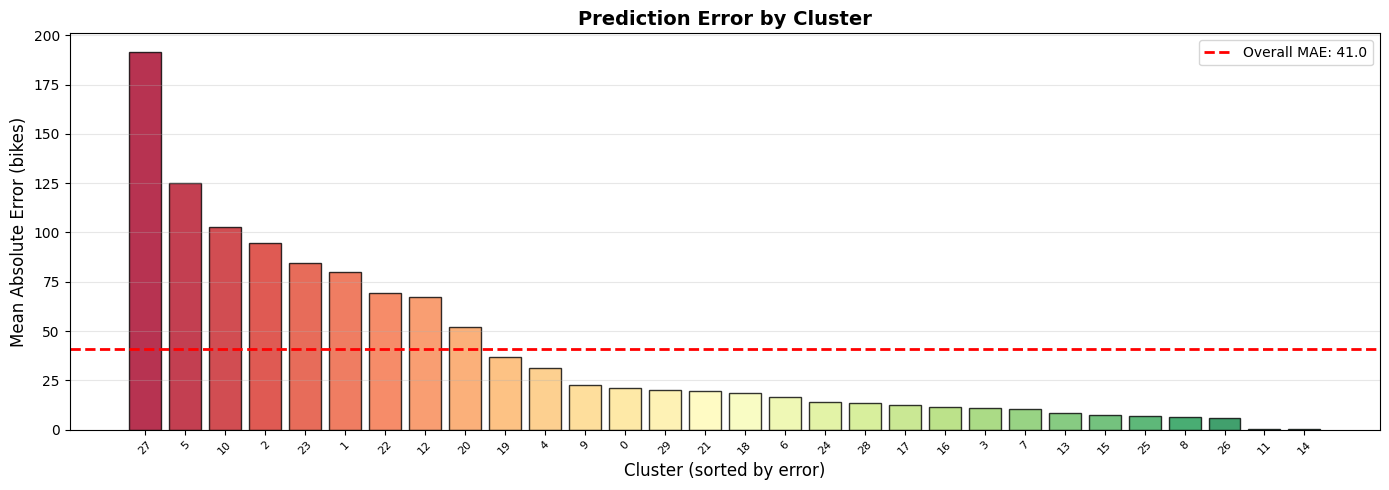


Error Distribution by Cluster:
  Best cluster (lowest MAE): Cluster 14 with MAE = 0.5
  Worst cluster (highest MAE): Cluster 27 with MAE = 191.5
  Median cluster MAE: 19.1
  Overall MAE: 41.0


In [48]:
# ============================================================================
# Visualization 3: Prediction Error by Cluster
# ============================================================================

# Calculate MAE per cluster
cluster_mae = daily_requirements.groupby('cluster')['abs_error'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 5))

colors = plt.cm.RdYlGn(np.linspace(0, 1, len(cluster_mae)))
bars = ax.bar(range(len(cluster_mae)), cluster_mae.values, color=colors, edgecolor='black', alpha=0.8)

# Overall MAE line
overall_mae = daily_requirements['abs_error'].mean()
ax.axhline(y=overall_mae, color='red', linestyle='--', linewidth=2, label=f'Overall MAE: {overall_mae:.1f}')

ax.set_xlabel('Cluster (sorted by error)', fontsize=12)
ax.set_ylabel('Mean Absolute Error (bikes)', fontsize=12)
ax.set_title('Prediction Error by Cluster', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(cluster_mae)))
ax.set_xticklabels([int(c) for c in cluster_mae.index], fontsize=8, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nError Distribution by Cluster:")
print(f"  Best cluster (lowest MAE): Cluster {int(cluster_mae.idxmin())} with MAE = {cluster_mae.min():.1f}")
print(f"  Worst cluster (highest MAE): Cluster {int(cluster_mae.idxmax())} with MAE = {cluster_mae.max():.1f}")
print(f"  Median cluster MAE: {cluster_mae.median():.1f}")
print(f"  Overall MAE: {overall_mae:.1f}")


## Pickups & Dropoffs: Predicted vs Actual

These visualizations compare the model's predictions for pickups and dropoffs against actual values.


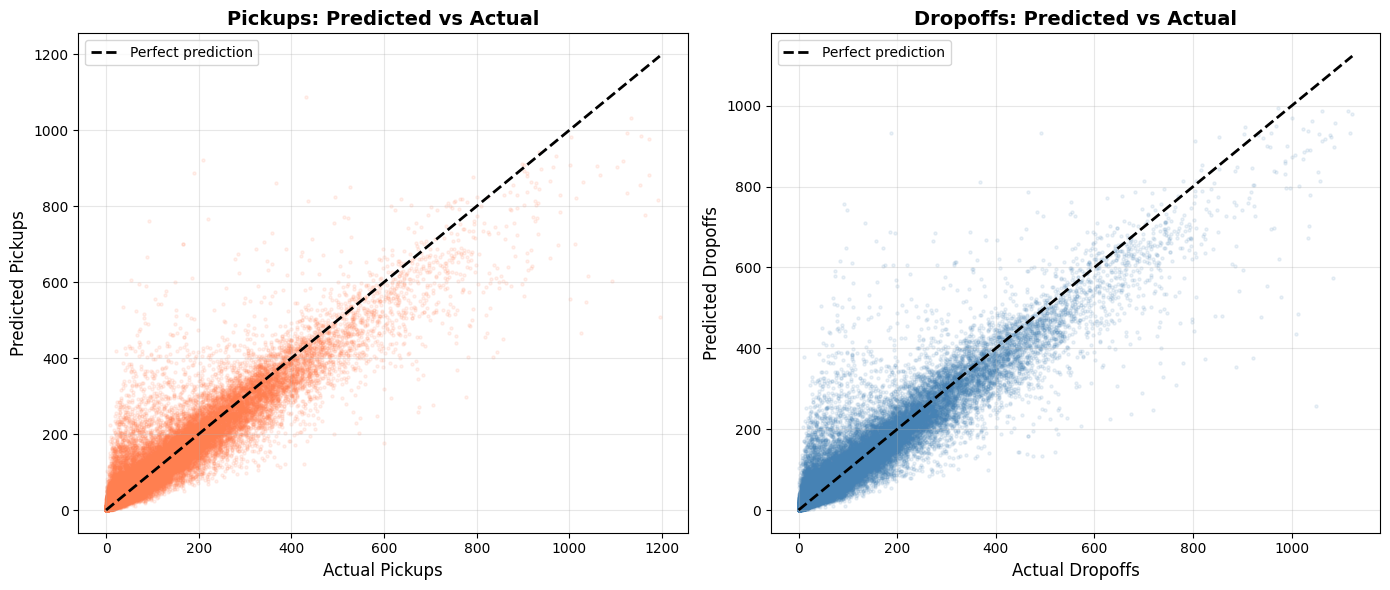


Test Set Performance:
  Pickups  - MAE: 18.17, R²: 0.8873
  Dropoffs - MAE: 18.03, R²: 0.8938


In [49]:
# ============================================================================
# Visualization: Pickups & Dropoffs - Predicted vs Actual (Scatter Plots)
# ============================================================================

# Generate predictions for entire test set
test_predictions = test_data.copy()
test_predictions['pred_pickups'] = model_pickups.predict(test_predictions[feature_cols].fillna(0))
test_predictions['pred_dropoffs'] = model_dropoffs.predict(test_predictions[feature_cols].fillna(0))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pickups scatter
ax1 = axes[0]
ax1.scatter(test_predictions['pickups'], test_predictions['pred_pickups'], 
            alpha=0.1, s=5, color='coral')
max_val = max(test_predictions['pickups'].max(), test_predictions['pred_pickups'].max())
ax1.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual Pickups', fontsize=12)
ax1.set_ylabel('Predicted Pickups', fontsize=12)
ax1.set_title('Pickups: Predicted vs Actual', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Dropoffs scatter
ax2 = axes[1]
ax2.scatter(test_predictions['dropoffs'], test_predictions['pred_dropoffs'], 
            alpha=0.1, s=5, color='steelblue')
max_val = max(test_predictions['dropoffs'].max(), test_predictions['pred_dropoffs'].max())
ax2.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Perfect prediction')
ax2.set_xlabel('Actual Dropoffs', fontsize=12)
ax2.set_ylabel('Predicted Dropoffs', fontsize=12)
ax2.set_title('Dropoffs: Predicted vs Actual', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate metrics
from sklearn.metrics import mean_absolute_error, r2_score
print("\nTest Set Performance:")
print(f"  Pickups  - MAE: {mean_absolute_error(test_predictions['pickups'], test_predictions['pred_pickups']):.2f}, R²: {r2_score(test_predictions['pickups'], test_predictions['pred_pickups']):.4f}")
print(f"  Dropoffs - MAE: {mean_absolute_error(test_predictions['dropoffs'], test_predictions['pred_dropoffs']):.2f}, R²: {r2_score(test_predictions['dropoffs'], test_predictions['pred_dropoffs']):.4f}")


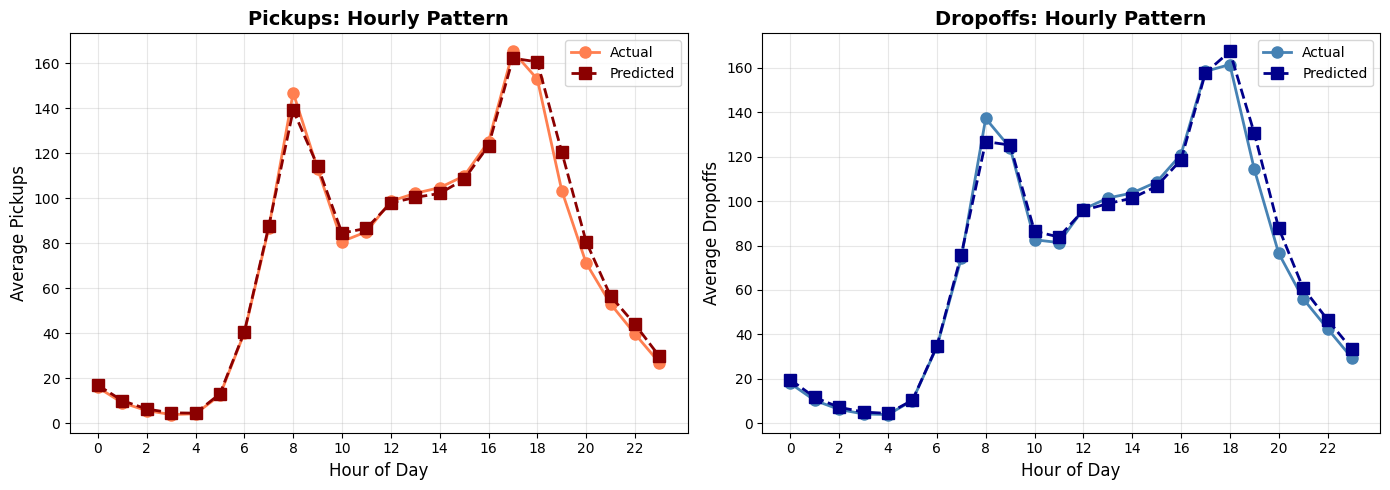


The model captures the daily demand pattern well!


In [50]:
# ============================================================================
# Visualization: Hourly Patterns - Predicted vs Actual by Hour of Day
# ============================================================================

# Aggregate by hour
hourly_comparison = test_predictions.groupby('hour').agg({
    'pickups': 'mean',
    'pred_pickups': 'mean',
    'dropoffs': 'mean',
    'pred_dropoffs': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pickups by hour
ax1 = axes[0]
ax1.plot(hourly_comparison['hour'], hourly_comparison['pickups'], 'o-', 
         linewidth=2, markersize=8, color='coral', label='Actual')
ax1.plot(hourly_comparison['hour'], hourly_comparison['pred_pickups'], 's--', 
         linewidth=2, markersize=8, color='darkred', label='Predicted')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Average Pickups', fontsize=12)
ax1.set_title('Pickups: Hourly Pattern', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 2))

# Dropoffs by hour
ax2 = axes[1]
ax2.plot(hourly_comparison['hour'], hourly_comparison['dropoffs'], 'o-', 
         linewidth=2, markersize=8, color='steelblue', label='Actual')
ax2.plot(hourly_comparison['hour'], hourly_comparison['pred_dropoffs'], 's--', 
         linewidth=2, markersize=8, color='darkblue', label='Predicted')
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Average Dropoffs', fontsize=12)
ax2.set_title('Dropoffs: Hourly Pattern', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

print("\nThe model captures the daily demand pattern well!")


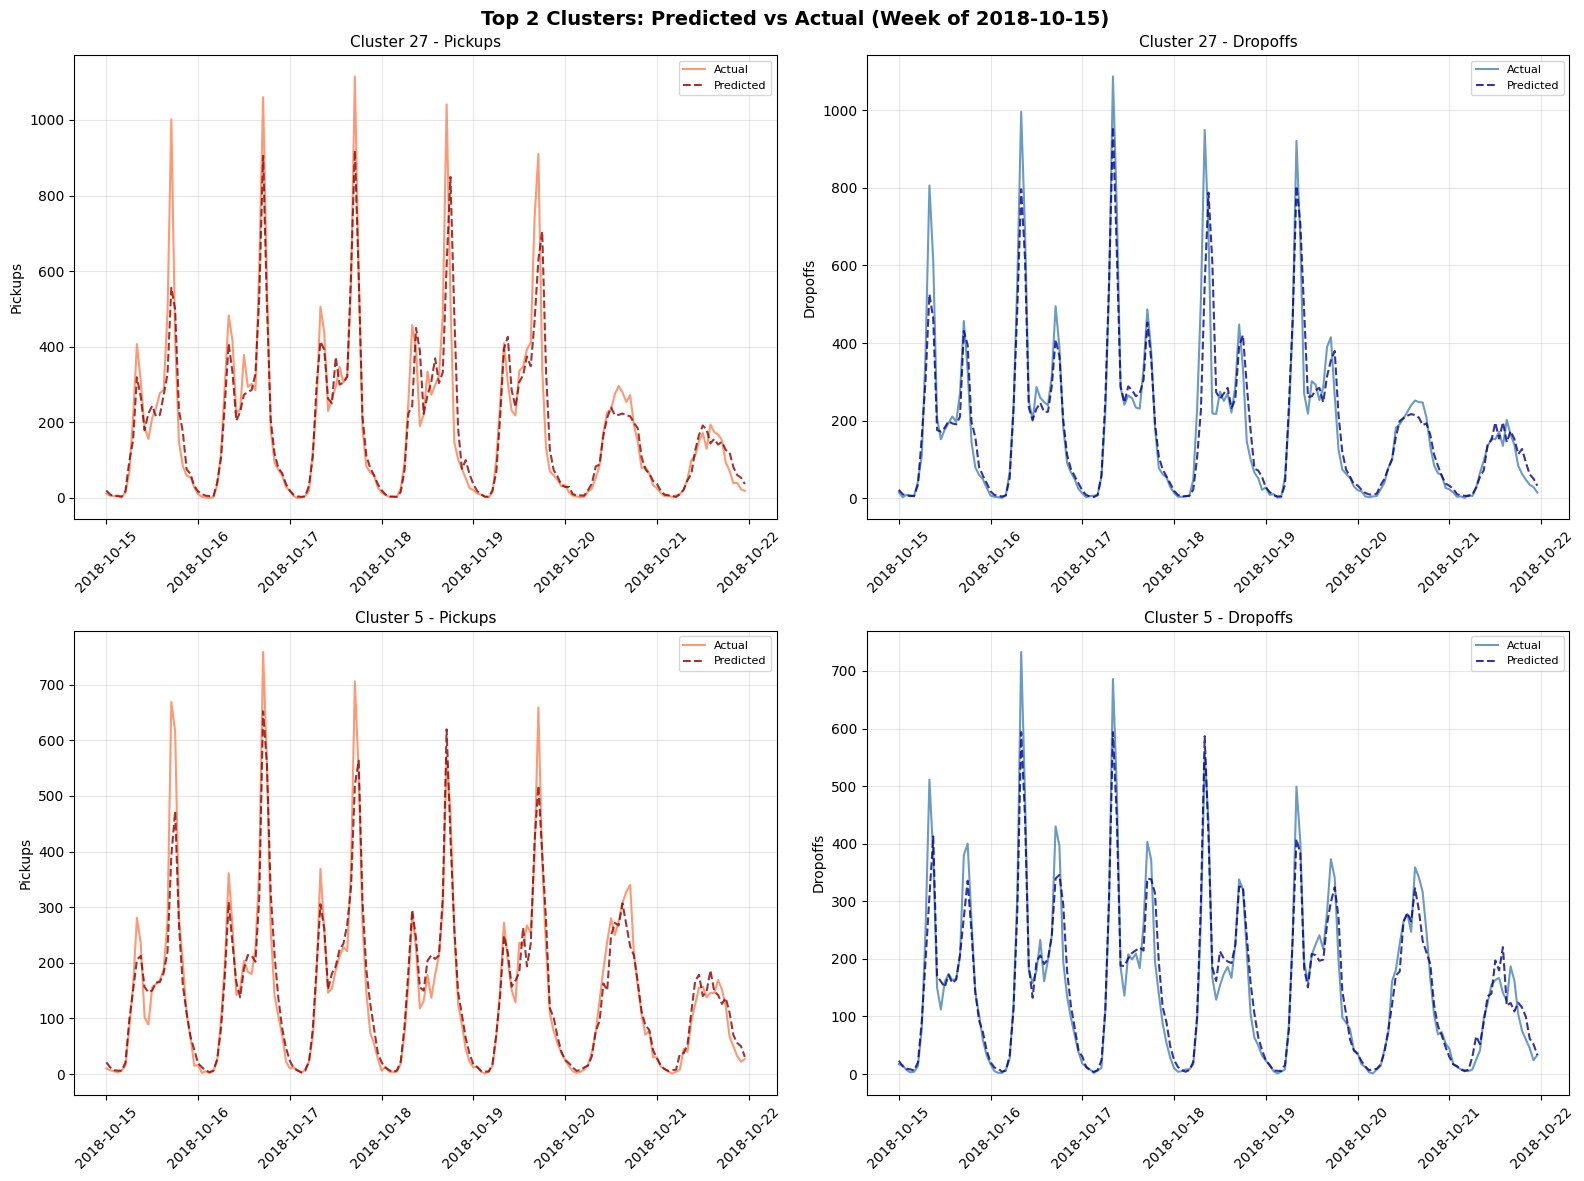


The model tracks the actual demand patterns closely across different clusters.


In [54]:
# ============================================================================
# Visualization: Time Series for Top 3 Clusters (One Week Sample)
# ============================================================================

# Get top 2 clusters by demand
top2_clusters = cluster_avg_needs.head(2).index.tolist()

# Select one week from test set
sample_start = pd.Timestamp('2018-10-15')
sample_end = pd.Timestamp('2018-10-22')
sample_data = test_predictions[
    (test_predictions['date'] >= sample_start) & 
    (test_predictions['date'] < sample_end) &
    (test_predictions['cluster'].isin(top2_clusters))
].copy()
sample_data['datetime'] = pd.to_datetime(sample_data['date']) + pd.to_timedelta(sample_data['hour'], unit='h')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Top 2 Clusters: Predicted vs Actual (Week of {sample_start.date()})', fontsize=14, fontweight='bold')

for i, cluster in enumerate(top2_clusters):
    cluster_data = sample_data[sample_data['cluster'] == cluster].sort_values('datetime')
    
    # Pickups
    ax1 = axes[i, 0]
    ax1.plot(cluster_data['datetime'], cluster_data['pickups'], 
             linewidth=1.5, color='coral', alpha=0.8, label='Actual')
    ax1.plot(cluster_data['datetime'], cluster_data['pred_pickups'], 
             linewidth=1.5, color='darkred', alpha=0.8, linestyle='--', label='Predicted')
    ax1.set_ylabel('Pickups', fontsize=10)
    ax1.set_title(f'Cluster {int(cluster)} - Pickups', fontsize=11)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Dropoffs
    ax2 = axes[i, 1]
    ax2.plot(cluster_data['datetime'], cluster_data['dropoffs'], 
             linewidth=1.5, color='steelblue', alpha=0.8, label='Actual')
    ax2.plot(cluster_data['datetime'], cluster_data['pred_dropoffs'], 
             linewidth=1.5, color='darkblue', alpha=0.8, linestyle='--', label='Predicted')
    ax2.set_ylabel('Dropoffs', fontsize=10)
    ax2.set_title(f'Cluster {int(cluster)} - Dropoffs', fontsize=11)
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nThe model tracks the actual demand patterns closely across different clusters.")


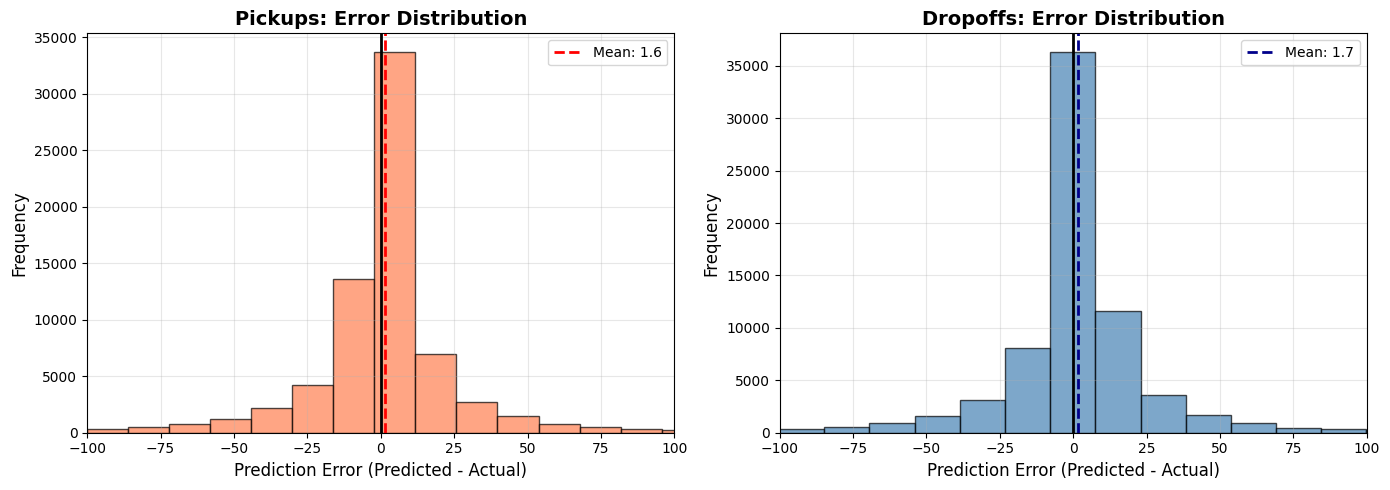


Error Statistics:
  Pickups  - Mean Error: 1.59, Std: 37.73
  Dropoffs - Mean Error: 1.70, Std: 37.20


In [52]:
# ============================================================================
# Visualization: Error Distribution (Histograms)
# ============================================================================

test_predictions['pickup_error'] = test_predictions['pred_pickups'] - test_predictions['pickups']
test_predictions['dropoff_error'] = test_predictions['pred_dropoffs'] - test_predictions['dropoffs']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pickup errors
ax1 = axes[0]
ax1.hist(test_predictions['pickup_error'], bins=100, color='coral', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.axvline(x=test_predictions['pickup_error'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {test_predictions["pickup_error"].mean():.1f}')
ax1.set_xlabel('Prediction Error (Predicted - Actual)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Pickups: Error Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-100, 100)

# Dropoff errors
ax2 = axes[1]
ax2.hist(test_predictions['dropoff_error'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax2.axvline(x=test_predictions['dropoff_error'].mean(), color='darkblue', linestyle='--', 
            linewidth=2, label=f'Mean: {test_predictions["dropoff_error"].mean():.1f}')
ax2.set_xlabel('Prediction Error (Predicted - Actual)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Dropoffs: Error Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-100, 100)

plt.tight_layout()
plt.show()

print("\nError Statistics:")
print(f"  Pickups  - Mean Error: {test_predictions['pickup_error'].mean():.2f}, Std: {test_predictions['pickup_error'].std():.2f}")
print(f"  Dropoffs - Mean Error: {test_predictions['dropoff_error'].mean():.2f}, Std: {test_predictions['dropoff_error'].std():.2f}")


Analyzing hourly predictions: Weekday vs Weekend comparison...

Selected dates for Cluster 27:
  Wednesday: 2018-12-26
  Saturday: 2018-12-15


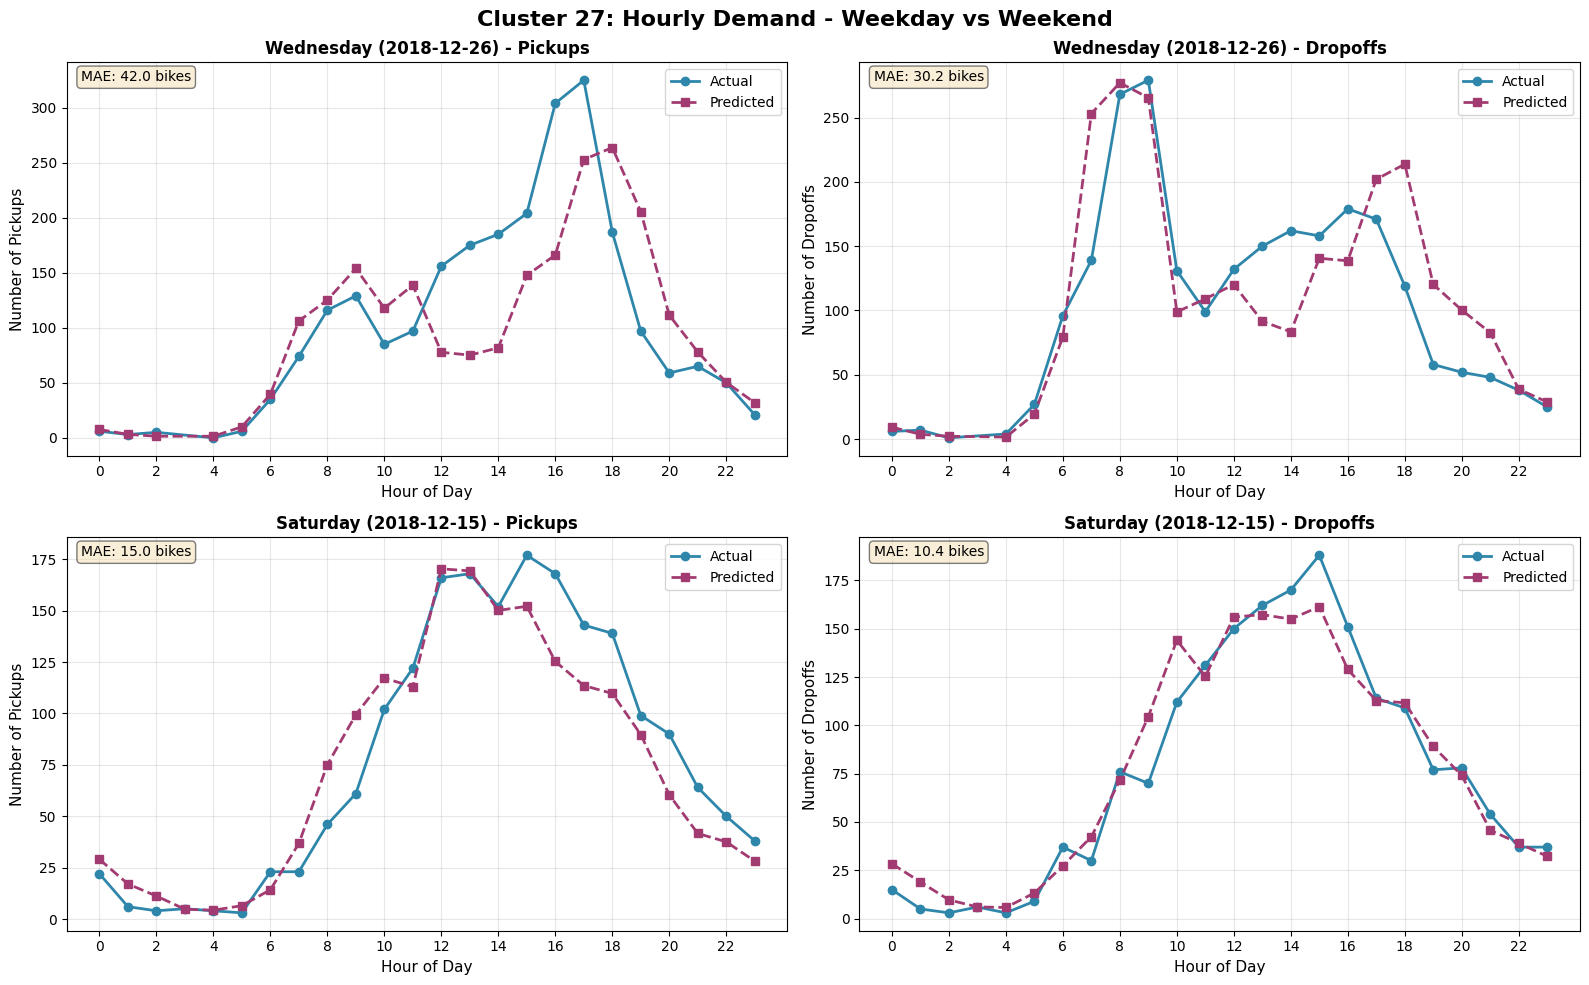


PREDICTION QUALITY SUMMARY

WEDNESDAY (2018-12-26):
  Pickups  - MAE: 42.0, Total Actual: 2384, Total Predicted: 2248
  Dropoffs - MAE: 30.2, Total Actual: 2349, Total Predicted: 2480

SATURDAY (2018-12-15):
  Pickups  - MAE: 15.0, Total Actual: 1875, Total Predicted: 1777
  Dropoffs - MAE: 10.4, Total Actual: 1824, Total Predicted: 1860


In [55]:
# ============================================================================
# Detailed Prediction Analysis: Weekday vs Weekend (Random Days from Test Set)
# ============================================================================

print("Analyzing hourly predictions: Weekday vs Weekend comparison...")
print("=" * 80)

# Use test_predictions which already has predictions
test_predictions['day_of_week'] = pd.to_datetime(test_predictions['date']).dt.dayofweek
test_predictions['day_name'] = pd.to_datetime(test_predictions['date']).dt.day_name()

# Pick a high-demand cluster for visualization
analysis_cluster = int(cluster_avg_needs.index[0])  # Highest demand cluster

# Filter for this cluster
cluster_data = test_predictions[test_predictions['cluster'] == analysis_cluster].copy()

# Find Wednesdays (day_of_week = 2) and Saturdays (day_of_week = 5)
wednesdays = cluster_data[cluster_data['day_of_week'] == 2]['date'].unique()
saturdays = cluster_data[cluster_data['day_of_week'] == 5]['date'].unique()

# Pick random dates
np.random.seed(123)
wednesday_date = pd.Timestamp(np.random.choice(wednesdays))
saturday_date = pd.Timestamp(np.random.choice(saturdays))

print(f"\nSelected dates for Cluster {analysis_cluster}:")
print(f"  Wednesday: {wednesday_date.date()}")
print(f"  Saturday: {saturday_date.date()}")

# Get data for these specific days
wed_data = cluster_data[cluster_data['date'] == wednesday_date].sort_values('hour')
sat_data = cluster_data[cluster_data['date'] == saturday_date].sort_values('hour')

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Cluster {analysis_cluster}: Hourly Demand - Weekday vs Weekend', 
             fontsize=16, fontweight='bold')

# Wednesday - Pickups
ax1 = axes[0, 0]
ax1.plot(wed_data['hour'], wed_data['pickups'], 
         'o-', linewidth=2, markersize=6, label='Actual', color='#2E86AB')
ax1.plot(wed_data['hour'], wed_data['pred_pickups'], 
         's--', linewidth=2, markersize=6, label='Predicted', color='#A23B72')
ax1.set_xlabel('Hour of Day', fontsize=11)
ax1.set_ylabel('Number of Pickups', fontsize=11)
ax1.set_title(f'Wednesday ({wednesday_date.date()}) - Pickups', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 2))
wed_mae_pickups = abs(wed_data['pickups'] - wed_data['pred_pickups']).mean()
ax1.text(0.02, 0.98, f'MAE: {wed_mae_pickups:.1f} bikes', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Wednesday - Dropoffs
ax2 = axes[0, 1]
ax2.plot(wed_data['hour'], wed_data['dropoffs'], 
         'o-', linewidth=2, markersize=6, label='Actual', color='#2E86AB')
ax2.plot(wed_data['hour'], wed_data['pred_dropoffs'], 
         's--', linewidth=2, markersize=6, label='Predicted', color='#A23B72')
ax2.set_xlabel('Hour of Day', fontsize=11)
ax2.set_ylabel('Number of Dropoffs', fontsize=11)
ax2.set_title(f'Wednesday ({wednesday_date.date()}) - Dropoffs', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 24, 2))
wed_mae_dropoffs = abs(wed_data['dropoffs'] - wed_data['pred_dropoffs']).mean()
ax2.text(0.02, 0.98, f'MAE: {wed_mae_dropoffs:.1f} bikes', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Saturday - Pickups
ax3 = axes[1, 0]
ax3.plot(sat_data['hour'], sat_data['pickups'], 
         'o-', linewidth=2, markersize=6, label='Actual', color='#2E86AB')
ax3.plot(sat_data['hour'], sat_data['pred_pickups'], 
         's--', linewidth=2, markersize=6, label='Predicted', color='#A23B72')
ax3.set_xlabel('Hour of Day', fontsize=11)
ax3.set_ylabel('Number of Pickups', fontsize=11)
ax3.set_title(f'Saturday ({saturday_date.date()}) - Pickups', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(0, 24, 2))
sat_mae_pickups = abs(sat_data['pickups'] - sat_data['pred_pickups']).mean()
ax3.text(0.02, 0.98, f'MAE: {sat_mae_pickups:.1f} bikes', 
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Saturday - Dropoffs
ax4 = axes[1, 1]
ax4.plot(sat_data['hour'], sat_data['dropoffs'], 
         'o-', linewidth=2, markersize=6, label='Actual', color='#2E86AB')
ax4.plot(sat_data['hour'], sat_data['pred_dropoffs'], 
         's--', linewidth=2, markersize=6, label='Predicted', color='#A23B72')
ax4.set_xlabel('Hour of Day', fontsize=11)
ax4.set_ylabel('Number of Dropoffs', fontsize=11)
ax4.set_title(f'Saturday ({saturday_date.date()}) - Dropoffs', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(range(0, 24, 2))
sat_mae_dropoffs = abs(sat_data['dropoffs'] - sat_data['pred_dropoffs']).mean()
ax4.text(0.02, 0.98, f'MAE: {sat_mae_dropoffs:.1f} bikes', 
         transform=ax4.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 80)
print("PREDICTION QUALITY SUMMARY")
print("=" * 80)
print(f"\nWEDNESDAY ({wednesday_date.date()}):")
print(f"  Pickups  - MAE: {wed_mae_pickups:.1f}, Total Actual: {wed_data['pickups'].sum():.0f}, Total Predicted: {wed_data['pred_pickups'].sum():.0f}")
print(f"  Dropoffs - MAE: {wed_mae_dropoffs:.1f}, Total Actual: {wed_data['dropoffs'].sum():.0f}, Total Predicted: {wed_data['pred_dropoffs'].sum():.0f}")
print(f"\nSATURDAY ({saturday_date.date()}):")
print(f"  Pickups  - MAE: {sat_mae_pickups:.1f}, Total Actual: {sat_data['pickups'].sum():.0f}, Total Predicted: {sat_data['pred_pickups'].sum():.0f}")
print(f"  Dropoffs - MAE: {sat_mae_dropoffs:.1f}, Total Actual: {sat_data['dropoffs'].sum():.0f}, Total Predicted: {sat_data['pred_dropoffs'].sum():.0f}")
